<a href="https://colab.research.google.com/github/AlexeyK12/Data_scientist-Sberuniversity/blob/main/Seminar13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 13
## Введение в задачи с временными рядами

На практике часто можно встретить данные, имеющие историю -- транзакции за последний год, звонки за последний месяц, температура в регионе. В таких задачах зачастую важно предсказать не какую-то величину в моменте, а ее поведение в будущем. Кроме того, информация, которая содержится в изменении того или иного показателя часто может быть важнее, чем текущее значение.

В данном обзоре мы разберем основные задачи анализа временных рядов, такие как:

* Статистический анализ
* Прогнозирование

Удачи!


In [ ]:
# Загрузим вспомогательные модули dataset.py и plotting.py
# Далее мы импортируем их как модули python, чтобы использовать реализованные в них функции

! pip install -U --no-cache-dir gdown --pre

! gdown https://drive.google.com/uc?id=1WHYiPvou_aaqMDtGnBXssffGJr8hIiHv
! gdown https://drive.google.com/uc?id=1kwVxbwrCojbcxPH0eYsjW5QAK_ALIgTy
! gdown https://drive.google.com/uc?id=175P7G7M3lTT7JM745Li90oZYA-RmBqqk

! unzip data.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1WHYiPvou_aaqMDtGnBXssffGJr8hIiHv
From (redirected): https://drive.google.com/uc?id=1WHYiPvou_aaqMDtGnBXssffGJr8hIiHv&confirm=t&uuid=2c0acf50-830c-4f20-b282-472342c7abb0
To: /content/dataset.py
100% 2.24k/2.24k [00:00<00:00, 6.91MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1kwVxbwrCojbcxPH0eYsjW5QAK_ALIgTy
From (redirected): https://drive.google.com/uc?id=1kwVxbwrCojbcxPH0eYsjW5QAK_ALIgTy&confirm=t&uuid=ed4915e8-04bd-4a21-9803-d81f12d23f5b
To: /content/plotting.py
100% 3.10k/3.10k [00:00<00:00, 12.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=175P7G7M3lTT7JM745Li90oZYA-RmBqqk
To: /content/data.zip
100% 1.02M/1.02M [00:00<00:00, 95.1MB/s]
Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/stability_in

In [ ]:
! ls

data  dataset.py  data.zip  __MACOSX  plotting.py  sample_data


## Статистический анализ

Прежде чем строить какие-либо модели, бывает крайне полезно посмотреть на ваши временные
ряды, покрутить их "туда-сюда", чтобы понять их основные характеристики. Это поможет вам
лучше понять, какой подход использовать или свести задачу к гораздо более простой. Иногда,
вдумчивый статистический подход сам по себе может являться моделью прогнозирования или
поиска аномалий, способную опередить ML и DL подходы.

Данная секция состоит из следующих частей:

1. Знакомимся с основными понятиями
2. Преобразования временных рядов
3. Как преобразовать ряд к стационарному
4. Разложения временных рядов, STL разложение

### Знакомимся с основными понятиями


#### **Что такое временной ряд?**


Временным рядов является любая упорядоченная последовательность чисел (или набора чисел), взятая с равными промежутками времени. На практике, мы всегда имеем дело с пропусками в данных, поэтому какими-то пропусками в данных приходится пренебрегать. Тем не менее, если вы имеете дело с числами, взятыми с совсем случайными интервалами, вы уже переходите в область стохастических процессов и теория, приведенная в данном обзоре, будет плохо к ним применима.

Итак, временной ряд формально:

$$
ts = \{(t_i, v_i): i \in {0...N}, v_i \in R^N, t_{i+1} - t_i = C \: \forall i\}
$$

В питоне наиболее подходящей структурой данных для работы с временным рядов является
`pandas.Series` (для хранения многомерных временных рядов используйте `DataFrame`)

In [ ]:
import pandas as pd
from random import randint

ts = pd.Series(
    data=[randint(0, 100) for _ in range(100)],
    index=pd.date_range(start='2022-08-05', freq='1H', periods=100)
)

ts

2022-08-05 00:00:00    83
2022-08-05 01:00:00    35
2022-08-05 02:00:00    61
2022-08-05 03:00:00    78
2022-08-05 04:00:00    45
                       ..
2022-08-08 23:00:00    33
2022-08-09 00:00:00    31
2022-08-09 01:00:00    39
2022-08-09 02:00:00    27
2022-08-09 03:00:00    44
Freq: H, Length: 100, dtype: int64

`data` любой итерируемый обьект
`index` также любой итерируемый обьект, равный по длине `data`. Для задач временных рядов
нам необходимо, чтобы он состоял из обьектов datetime, создать которые можно либо
средствами стандартной библиотеки datetime либо средствами pandas. Обратите внимание, что,
чтобы задавать временные интервалы, нужно использовать стандарт ISO8601 (подробнее [здесь](#ref_1))


В нашем туториале мы будем использовать разные временные ряды в качестве примеров. Для удобной работы с ними, вы можете использовать класс `Dataset` из модуля `dataset` в корне вашего репозитория.

In [ ]:
from dataset import Dataset

ds = Dataset('./data/dataset')

# посмотреть временные ряды
print(ds)

# достать конкретный временной ряд
ds['international-airline-passengers.csv']

# проитерироваться по всем рядам
for key, s in ds:
    pass

hour_3380.csv
alcohol_sales.csv
day_1007.csv
hour_3387.csv
hour_3621.csv
hour_3019.csv
day_687.csv
day_929.csv
day_478.csv
day_2308.csv
day_915.csv
day_446.csv
dow_jones_2.csv
day_1762.csv
day_1158.csv
day_1206.csv
day_2888.csv
day_1039.csv
day_3376.csv
day_1159.csv
day_3015.csv
day_1776.csv
day_2493.csv
day_2531.csv
day_321.csv
day_2069.csv
day_3610.csv
day_493.csv
hour_3192.csv
day_2685.csv
day_1164.csv
daily-min-temperatures.csv
hour_3594.csv
international-airline-passengers.csv
day_309.csv
dow_jones_1.csv
day_1403.csv
day_2108.csv
day_2256.csv
day_1832.csv
day_1761.csv
day_1173.csv
stl_example.csv
hour_376.csv
day_2875.csv
hour_3426.csv
hour_2098.csv
day_2336.csv
day_3148.csv
day_1574.csv
day_2135.csv
day_718.csv
hour_3553.csv
std_example.csv
hour_1804.csv
day_335.csv
hour_3618.csv
day_2283.csv
day_1777.csv
day_724.csv
day_1167.csv
hour_2263.csv
day_2281.csv
day_2690.csv
day_2450.csv
hour_3625.csv
dow_jones_3.csv
dow_jones_0.csv
day_2915.csv
day_1601.csv
day_2334.csv
day_2901.csv


#### **Графики временных рядов**

Любой анализ временных рядов предполагает визуализацию данных, для этого нам необходимо
уметь рисовать графики временных рядов. Самый простой способ - использовать встроенный
метод `plot` обьекта series.

<Axes: >

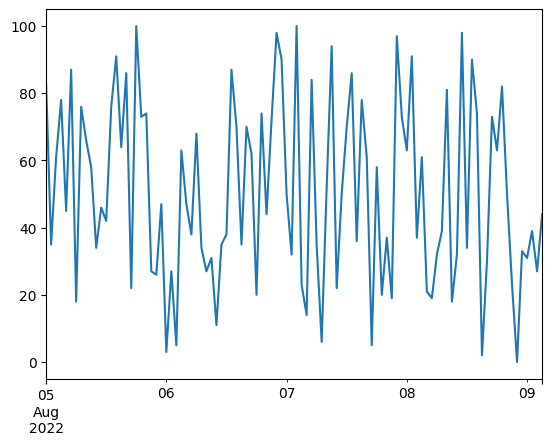

In [ ]:
ts.plot()

Тем не менее, есть более интерактивные варианты для отрисовки графиков, такие как
библиотеки bokeh и plotly, например. Можете использовать функцию `plot_ts` из корня вашего
репозитория, как пример.

Обратите внимение, насколько информативнымии становятся графики!

In [ ]:
from plotting import plot_ts

plot_ts(ts)

#### **Гранулярность временного ряда или частота**

Гранулярностью временного ряда (или частотой) называется временной интервал между двумя
соседними точками временного ряда. Она показывает, насколько "плотно" распределены точки в
истории.

In [ ]:
print((ts.index[1] - ts.index[0]))

0 days 01:00:00


#### **Лаг(-и) временного ряда**

Работая с временными рядами, вы будете часто слышать термин `лаг`. Данный термин может
быть употребим либо по отношению ко всему временному ряду, либо по отношению к конкретной
точке $(t_i, v_i)$.

Когда термин лаг используется в контексте точки, `k-ый лаг` для
точки $(t_i, v_i)$ означает точку $(t_{i-k}, v_{i-k})$ вглубь истории.

Будучи применен ко всему ряду `k-ый лаг` означает ряд, сдвинутый `k` раз вправо (назад во
времени), таким образом, что каждая точка $(t_i, v_i)$ становится точкой $(t_i, v_{i-k})$

In [ ]:
plot_ts(ts, ts.shift(10))

#### **Горизонт прогнозирования**

*Горизонтом прогнозирования h называют количество точек в будущее, на которое делается прогноз, обычно пишут $Y_{t+h}$.*

#### **Автокорреляция**

Практически во всех задачах анализа временных рядов важно знать, содержит ли ваш ряд
какую-либо временную зависимость (т.е. коррелируют ли точки из прошлого с точками из будущего),
потому что прогнозирование временных рядов без доп признаков основано исключительно
на прошлых значениях временного ряда. Одним из лучших способов найти такую зависимость
является расчет автокорреляции, т.е. корреляции между изначальным временным рядом и рядом,
сдвинутым назад во времени.

Говоря математически, автокорреляция ряда $Y_t$ при $k$-ом лаге определяется как хорошо
известная корреляция Пирсона, взятая от двух рядов, изначального и взятого с лагом $k$.

$$\rho_{Y_t, Y_{t-k}} = \frac{\operatorname{cov}({Y_{t-k}},Y_t)}{\sigma_{Y_{t-k}} \sigma_{Y_t}} = \frac{E[(Y_t-\mu_{Y_t})(Y_{t-k}-\mu_{Y_{t-k}})]}{\sigma_{Y_{t-k}} \sigma_{Y_t}}$$

Большие значения автокорреляции на каком либо лаге $k$ сигнализируют, что вы, возможно,
имеете сильную периодческую зависимость с периодом $1/k$.

In [ ]:
# В питоне, вы можете легко посчитать корреляцию при помощи метода `corr` обьекта series

ts.corr(ts.shift(10))

-0.03510624630874377

#### **Частичная автокорреляция**

Когда мы расчитываем автокорреляцию ряда $Y_t$ при лаге $K$, мы подразумеваем, что все промежуточные лаги тоже могут вносить определенный вклад в разброс значений $Y_t$.


Но, что если мы хотим узнать, как зависит ряд в текущий момент времени от лага $K$, если убрать влияние всех промежуточных лагов? Тогда, мы должны сначала построить линейную регрессию ряда $Y_t$ на все промежуточные значения $Y_{t-1}$, $Y_{t-2}$, ..., $Y_{t-K+1}$. После чего вычесть прогноз регрессии из исходного ряда. Тогда, автокорреляция полученного ряда при лаге $K$ будет являться частичной автокорреляция исходного ряда при этом же лаге.


Формально, частичная корреляция определяется следующим образом:

$$
\text{pacf}(y_t, y_{t-k}) =
\begin{cases}
    \text{corr}(y_{t-k}, y_t) , k=1,\\
    \text{corr}(y_{t-k} - y_{t-k}^{'}, y_t - y_t^{'}),k>1,
\end{cases},
$$

где $y_{t}'$ - линейная регрессия на $y_{t-1}, y_{t-2}, ..., y_{t-k+1}$,  
т.е. $y_{t}' = \alpha_1 y_{t-1}' + \alpha_2 y_{t-2}' + ... + \alpha_{k-1} y_{t-k+1}'$
и аналогично для $y_{t-k}'$

In [ ]:
# в питоне частичную автокорреляция можно посчитать при помощи функции pacf из statsmodels
from statsmodels.tsa.stattools import pacf

pacf(ts, 30)

array([ 1.00000000e+00, -3.33932153e-02, -2.93182081e-02,  1.25017660e-01,
        3.19589705e-02, -1.68389463e-01, -1.26841964e-01,  5.36591404e-03,
       -5.68324803e-02,  1.15184000e-01, -5.89932868e-02, -2.15321235e-02,
        2.66028351e-02, -6.03151068e-02,  6.39124634e-02, -7.26244029e-04,
       -3.99234021e-02, -3.32159516e-02,  2.55848981e-02,  2.40343966e-01,
       -1.89088307e-01,  4.88400080e-02, -1.60478811e-01,  1.70903714e-02,
       -3.37240965e-02,  1.98375222e-01, -1.06912188e-01, -1.35466436e-01,
        6.22760689e-02, -1.40643355e-01,  6.98913624e-02])

#### **Графики acf и pacf**

Зависимость значения автокорреляции (частичной автокорреляции) от порядка лага называется
графиком автокорреляции или графиком частичной автокорреляции.

Графики автокорреляции используются для того, чтобы посмотреть, есть ли у временного ряда
какая либо временная зависимость. Например, для ряда белого шума, график автокорреляции
будет выглядеть как шум, без значимых пиков, а для ряда $sin(t)$ график автокорреляции
будет выглядеть как $sin(t)$

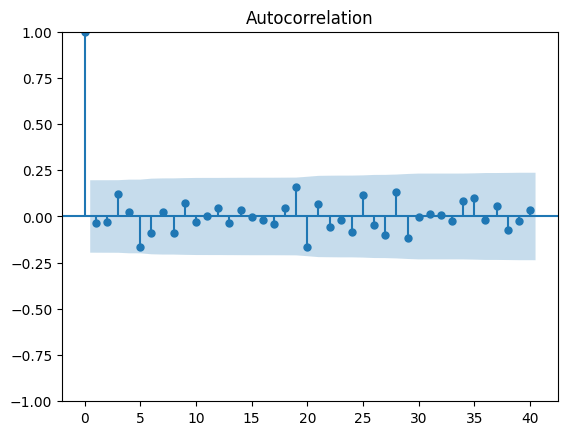

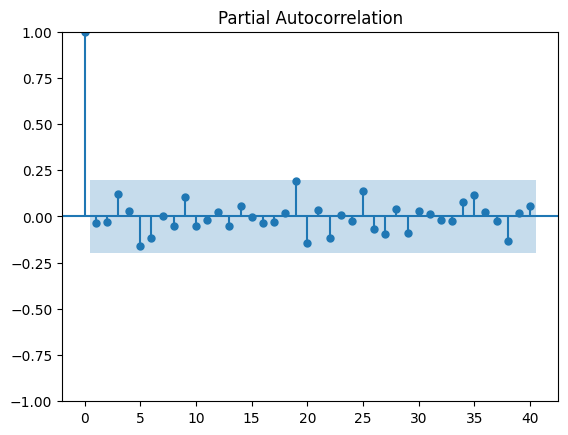

In [ ]:
# в питоне готовые функции для отрисовки можно найти в библиотеке statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts, lags=40);
plot_pacf(ts, lags=40);

На графиках выше можно заметить, что какая либо структура в данных отсуствуют, т.к. мы
наблюдаем 100% корреляцию при нулевом лаге (когда ряд совпадает сам с собой) и случайные
корреляции на всех остальных лагах. Т.к. мы изначально генерировали случайный ряд, такой
результат очевиден.

#### **Компоненты временного ряда**

Каждый временной ряд может содержать одну (или несколько) следующих компонент
временного ряда:

* Гетероскедастичность
* Тренд
* Сезонность
* Цикличность
* Шум

##### **Гетероскедастичность**

Непостояноство дисперсии временного ряда называется гетероскедастичностью, на примере ниже
можно видеть, как ряд имеет возрастающую дисперсию.

In [ ]:
ts = ds['alcohol_sales.csv']

# первый график показывает изначальный ряд, второй график - скользящее std
plot_ts(ts, ts.rolling(12).std())

##### **Тренд**

У тренда нет четкого формального определения, в целом его можно охарактеризовать
как долговременную тенденцию к изменению временного ряда. Часто, когда говорят о тренде, имеют ввиду линейный тренд, но он вообще говоря может быть полиномом произвольной степени.

Обнаружить тренд легко можно на самом графике временного ряда либо на графике
автокорреляции, ряды с трендом на нем выглядят как убывающая или возрастающая (зачастую монотонно) зависимость.

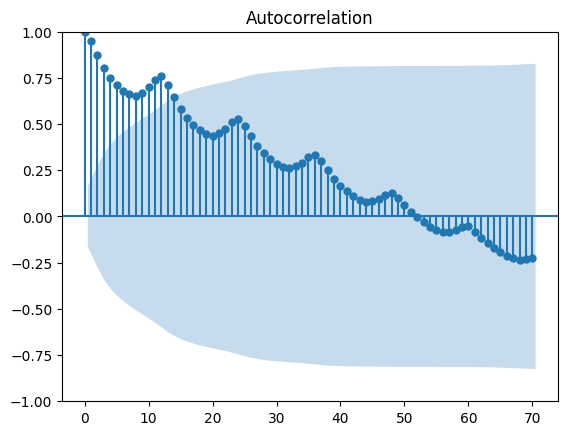

In [ ]:
ts = ds['international-airline-passengers.csv']
plot_ts(ts)
# видим линейно автокорреляцию с ростом порядка лага, что свидетельствует о наличии тренда
plot_acf(ts, lags=70);

##### **Сезонность и период сезонности временного ряда**

Если $y_t = y_{t-s} + e(t), \; \forall t$, где $e(t)$ - шум, то говорят, что временной ряд имеет сезонность с периодом s.

**NOTE:** тут мы подразумеваем, что мы исключили все остальные компоненты, включаю другие сезонности.

Определить сезонность можно либо по графику самого временного ряда, либо по графику автокорреляции -- если на графике автокорреляции вы наблюдаете периодические всплески автокорреляции через равные промежутки времени, то ряд скорее всего имеет сезонность.

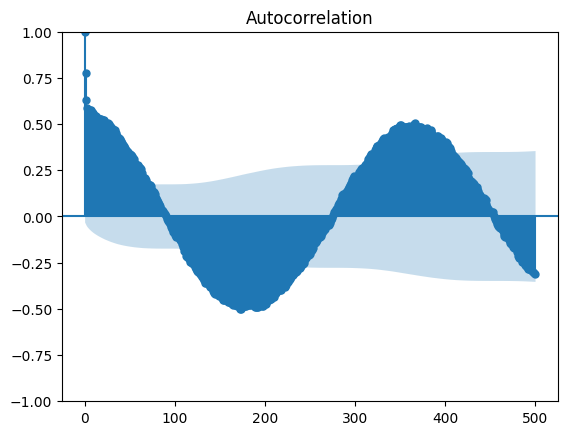

In [ ]:
ts = ds['daily-min-temperatures.csv']

plot_ts(ts)
plot_acf(ts, lags=500);

##### **Цикличность**

*Если временной ряд имеет повторяющийся паттерн, но, в отличии от сезонности, период его не является постоянным, то мы имеем дело с цикличностью.*

##### **Шум**

Если мы исключим из временного ряда все вышеперечисленные компоненты, то все, что у нас останется, является случайной частью временного ряда - неким шумом из некоего распределения.

В эту же компоненту входят выбросы и различные аномалии.

График автокорреляций для шума не должен содержать каких-либо значимых автокорреляций.

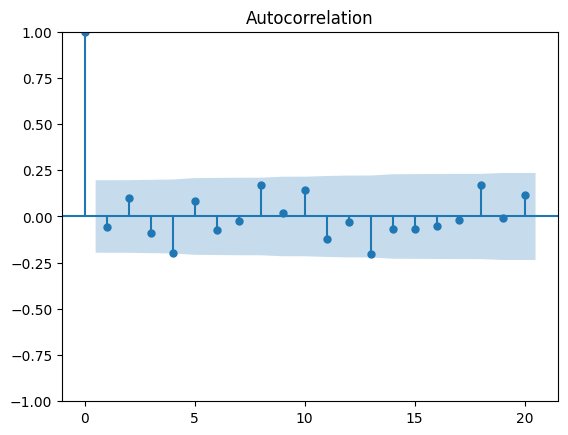

In [ ]:
from random import randint

ts = pd.Series(
    data=[randint(0, 100) for _ in range(100)],
    index=pd.date_range(start='2022-08-05', freq='1H', periods=100)
)

plot_ts(ts)
plot_acf(ts);

#### **Понятие стационарности временного ряда**

Одним из ключевых понятий в классическом, эконометрическом анализе временных рядов
является понятие стационарности. Познакомимся с ним подробнее.

##### *Определение*

Формально временной ряд $y_1, y_2, ..., y_t$ называется стационарным, если $\forall s$ распределение $y_t, ..., y_{t+s}$ не зависит от времени, а именно:

* $\text{VAR}(y_t) = const$
* $\text{E}(y_t) = const$
* $\text{COV}(y_t, y_{t-k}) = const \forall k$

##### *Интуитивное определение*

Говоря неформальным языком, стационарным временным рядом является такой временной ряд,
который мы избавили от любой формы "непостоянства".

По сути, все компоненты временного ряда, за исключением шума, представляют собой ту или
иную форму "непостоянства" во временном ряде. Гетероскедастичность показывает
непостоянство дисперсии, тренд и сезонность - изменчивость матожидания. Как мы узнаем
немного позже, умение "убирать" из временного ряда все возможные формы непостоянства -
ключевой навык для построения классических моделей прогнозирования. Сделать это можно при
помощи различных преобразований временного ряда.

#### **Как убедиться, что ряд стационарен**



Есть два основных способа убедиться в стационарности временного ряда.

1. Используя визуальный анализ исходного графика и графика автокорреляции.
2. Используя статистические тесты.

##### **Визуальный анализ**

При визуальном анализе мы обращаем внимание на то, есть ли у временного ряда непостоянные
компоненты - гетероскедастичность, тренд, сезонность. Обратите внимание, что цикличность
не является компонентной непостоянства, так как период цикличности является случайной
величиной и матожидание, дисперсия и ковариация данного процесса будут константными.

Давайте посмотрим на пример ниже. В изначальном ряде на обоих графиках мы наблюдаем и
тренд и сезонность и гетероскедастичность. Данный ряд явно не является стационарным.

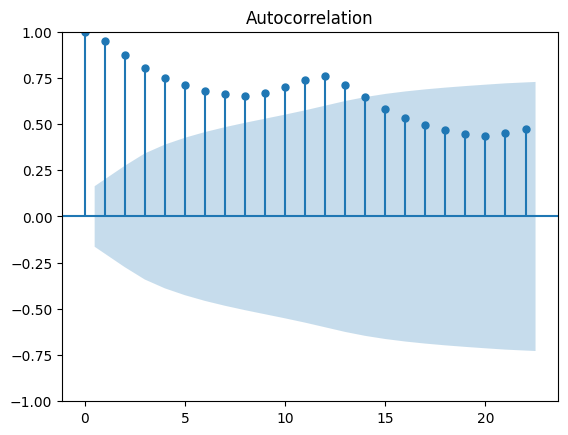

In [ ]:
ts = ds['international-airline-passengers.csv']

plot_ts(ts)
plot_acf(ts);

Теперь рассмотрим график белого шума.

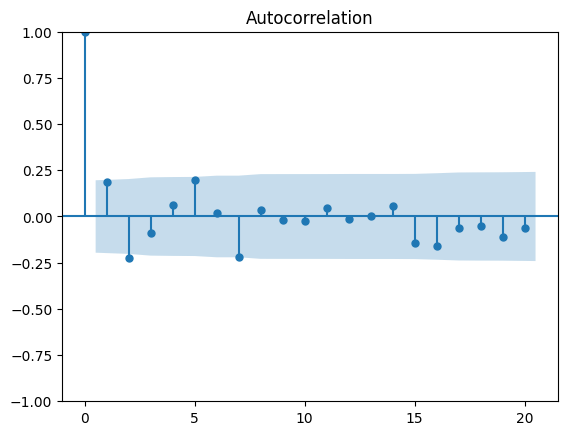

In [ ]:
ts = pd.Series(
    data=[randint(0, 100) for _ in range(100)],
    index=pd.date_range(start='2022-08-05', freq='1H', periods=100)
)

plot_ts(ts)
plot_acf(ts);

Здесь мы не видим никакого тренда, сезонности или гетероскедастичности. А график
автокорреляции показывает резкий спад корреляции в незначимый диапазон сразу после 0-го
лага. Этот ряд явно стационарен.

##### **Статистические тесты**

Вторым способом является проверка ряда на стационарность при помощи какого-нибудь статистического теста. Два самых популярных теста для проверки ряда на стационарность - тест [KPSS](#ref_3) и [Dicky-Fuller](#ref_4). Мы будем использовать второй. В рамках  данного обзора мы не будем вдаваться в теорию, стоящую за данными тестами, и будем  использовать их как "black box".

Нулевой гипотезой теста является предположение о том, что ряд не стационарен. Если значение p-value меньше определенного порога (обычно 5%), мы можем смело отвергнуть нулевую  гипотезу и считать ряд стационарным.

На примере ниже мы видим, что значение p-value сильно меньше 5 процентов, соотвественно мы смело отвергаем нулевую гипотезу и говорим, что ряд с большой долей уверенности можно назвать стационарным.

In [ ]:
from statsmodels.tsa.stattools import adfuller

ts = pd.Series(
    data=[randint(0, 100) for _ in range(100)],
    index=pd.date_range(start='2022-08-05', freq='1H', periods=100)
)

p_value = adfuller(ts)[1]
p_value

0.0059116915243103635

На не стационарном ряде мы видим, наоборот, большие значение p-value, соотвественно, не
можем отвергнуть нулевую гипотезу и говорим, что ряд не стационарен.

In [ ]:
ts = ds['international-airline-passengers.csv']

p_value = adfuller(ts)[1]
p_value

0.991511509628866

Тем не менее, автоматического способа, который со 100% гарантией давал бы вам вердикт о
стационарности не существует, к тому же условие стационарности, как и любое другое
статистическое понятие, может определяться лишь с некоей вероятностью. Поэтому этот
требует некоего опыта.

>Посмотрите картинку ниже, как вы думаете, какие из данных рядов можно назвать
стационарными?

<img src="https://raw.githubusercontent.com/technogleb/ts_walkthrough/master/ts_types.png" alt="drawing" width="400">

Стационарными рядами можно назвать ряды b, g.

### Преобразования временных рядов

Преобразования временных рядов позволяют вам избавиться от всех нестационарных компонент.
Рассмотрим основные преобразования.

#### **Временные преобразования временного ряда**

Представьте, что вам дали задачу спрогнозировать среднегодовую минимальную температуру в определенном районе, при этом у вас имеются данные минимальной температуры за каждый день в течении нескольких лет. Для того чтобы спрогнозировать температуру на следующий год, вам необходимо сделать прогноз на 365 дней вперед и потом усреднить значение. Тем не менее, такая задача может быть весьма сложной. Однако, на самом деле, вам не нужно знать температуру на каждый день - вместо этого вы можете взять среднее значение за каждый год и спрогнозировать уже этот, новый, годичный ряд. Таким образом перейти от дневной гранулярности к годичной. Такие преобразования называется временными.

>Попробуем расчитать среднее значение температуры на следующий год для ряда
>`daily-min-temperatures.csv`, используя временное преобразование. Для этого рассчитайте
>среднее за каждый год и перейдите к годичному ряду, после чего посмотрите на ряд и оцените
>среднее значение температуры на следующий год.

In [ ]:
ts = ds['daily-min-temperatures.csv']
years = {dt.year for dt in ts.index}

year_min_temperatures = {
    str(year): ts[f'{year}'].mean()
    for year in years
}

ts_year = pd.Series(year_min_temperatures)

ts_year.index = pd.to_datetime(ts_year.index)

ts_year.sort_index(inplace=True)

plot_ts(ts_year)

# видим, что оптимальным прогнозом температуры на 91 год будет значение где-то от 11.3 до 12

#### **Логарифмирование временного ряда**

Самым простым способом убрать непостоянство дисперсии во временном ряде является операция
логарифмирования.

$$y_t^{log} = log{y_t}$$

>Попробуйте применить операцию логарифмирования к ряду `alcohol_sales.csv` и посмотрите как
>изменится ряд. Получилось ли убрать непостоянство дисперсии?

In [ ]:
ts = ds['alcohol_sales.csv']

import numpy as np

plot_ts(ts, ts.rolling(12).std())

# Воспользуемся, например, логарифмом
plot_ts(np.log(ts), np.log(ts).rolling(12).std())

# видим, что непостоянство дисперсии действительно ушло

Развитием идеи логарифмирования ряда является преобразование Бокса-Кокса, которое предполагает трансформация ряда при помощи произвольной степенной функции. Данное преобразование мы оставим за рамками данного обзора.

#### **Дифференцирование временного ряда (или взятие разностей)**

Убрать тренд или сезонность проще всего при помощи дифференцирования временного ряда, т.е. перейдя от асболютных величин к их разностям, кроме того, работая с временными рядами, очень часто хочется посмотреть не на сам ряд, а на его изменение. Чтобы можно было сказать, насколько ряд меняется с каждой новой точкой, или,
скажем, насколько у дневного ряда различаются значения вчера и сегодня.

Пусть имеется ряд $y_t$, тогда, дифференцированным с лагом $k$ будет называться ряд вида
$y_t' = y_t - y_{t-k}$

Для операции дифференцирования также часто вводят понятие порядка $d$. Дифференцированным
рядом порядка $d$ с лагом $k$ называется ряд, который $d$ раз продифференцирован с лагом
$k$.

В питоне операцию дифференцирования легко осуществить при помощи метода `diff` класса
TimeSeries.

In [ ]:
ts = ds['international-airline-passengers.csv']
plot_ts(ts)

In [ ]:
ts = ds['international-airline-passengers.csv']

# взятие первой разности с лагом 1
plot_ts(ts.diff())

In [ ]:
# взятие первой разности с лагом 12
plot_ts(ts.diff(12))

In [ ]:
# взятие первой и второй разности с лагом 1
plot_ts(ts.diff().diff())

In [ ]:
# можно также комбинировать порядок и лаг
plot_ts(ts.diff().diff(12))

In [ ]:
# посмотрим, как все выглядит на графике
plot_ts(ts, ts.diff(), ts.diff(12))

>Попробуем избавить ряд `daily-min-temperatures` от сезонности при помощи операции дифференцирования

In [ ]:
ts = ds['daily-min-temperatures.csv']

ts_diff = ts.diff(365)

plot_ts(ts, ts_diff)

### Приведение ряда к стационарному

>Используя вышеперечисленные преобразования, приведем ряд alcohol_sales.csv к
>стационарному виду. Критерием стационарности должны служить соотвествующий график
>автокорреляции и низкое значение p-value статистики Дики-Фуллера

In [ ]:
ts = ds['alcohol_sales.csv']

plot_ts(ts)

# сначала убираем гетероскедастичность логарифмированием
ts_log = np.log(ts)

In [ ]:
# теперь избавляемся от тренда при помощи дифференцирования
ts_diff = ts_log.diff()

In [ ]:
# далее избавимся от сезонности при помощи дифференцирования с лагом равным периоду сезонности,
# в данном случае - 12
ts_diff = ts_diff.diff(12)

6.3518815832702615e-12

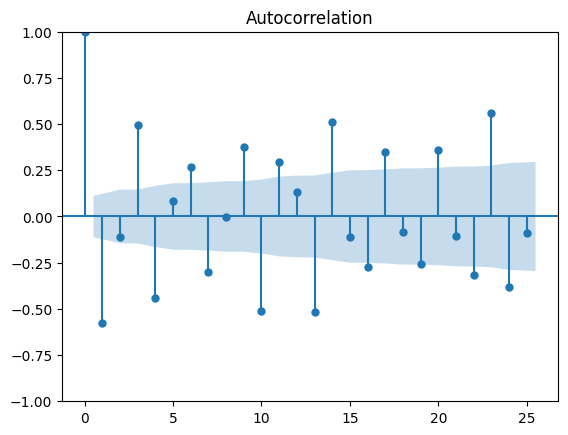

In [ ]:
plot_acf(ts_diff.dropna());
adfuller(ts_diff.dropna())[1]

# видим, что график автокорреляции не показывает никаких осмысленных закономерностей, а значение p-value
# очень низко, что явно свидетельствует о стационарности полученного ряда

### STL разложение

Зачастую, временной ряд можно разложить на три компоненты: тренд, сезонность и остаток.

В таком случае, мы можем сильно упростить себе задачу прогнозирования такого ряда - ведь вместо того, чтобы прогнозировать весь ряд целиком, мы можем спрогнозировать отдельно тренд, сезонность и остаток, которые почти наверняка будут иметь более простую структуру, нежели изначальный ряд, после чего сложить полученные прогнозы. Именно на этом основан метод `STL(seasonal-trend-loess)`разложения.

Разберем наивную реализацию алгоритма STL.

**NOTE:** Оригинальная статья, предложившая данный метод, подразумевает реализацию loess регрессии, но мы, для простоты, будет использовать вместо нее медианный фильтр и предположение о линейности тренда.

Пусть имеется временной ряд $Y_t$, представимый в виде суммы тренда $T_t$, сезонности $S_t$, остатка $R_t$, т.е. $Y_t = T_t + S_t + R_t$ (с поправкой на возможную гетероскедастичность), тогда:

1. Первым делом уберем гетероскедастичность.

$$Y_t = \log(Y_t)$$

2. Далее найдем тренд, построив линейную регрессию Y(X).

$$T_t = \alpha X_t + \beta$$
$$\alpha,\beta: \text{MSE}(T, Y) → min$$

3. Вычтем тренд из ряда Y_t

$$Y_t^{detrended} = Y_t - T_t$$

4. Чтобы получить сезонность и остаток, применим дифференцирование с лагом, равным периоду сезонности. Тогда, полученный в результате дифференцирования ряд будет остатком $R_t$, а сезонность может быть получена, как:

$$S_t = Y_t^{detrended} - R_t$$

6. Признаком хорошего разложения будет служить стационарность остатков.

$\;$

Теперь, разложив ряд на компоненты, можем сделать прогноз каждой компоненты, после чего сложить получившиеся прогнозы, чтобы получить прогноз исходного ряда.

1. Прогноз тренда получается интерполяцией найденной зависимости

$$T_{t+h} = \alpha X_{t+h} + \beta$$

2. Прогноз сезонности получается рекурсивно

$$S_{t+h} = S_{t+h-s}$$

3. Остатки нужно по-хорошему прогнозировать моделью ARMA. Но в нашем случае положим остатки нулю, таким образом, не учтя их в прогнозе.

$$R_{t+h} = 0$$

4. Итоговый прогноз получим как сумму всех компонент

$$Y_{t+h} = T_{t+h} + S_{t+h} + R_{t+h}$$

Сделаем прогноз ряда `stl_example.csv` на 36 лагов вперед при помощи stl разложения.

In [ ]:
ts = ds['stl_example.csv']

# уберем гетероскедастичность логарифмированием
ts = np.log(ts)

In [ ]:
plot_ts(ts)

In [ ]:
# найдем тренд, построив линейную регрессию на шкалу абсцисс
# NOTE: можно воспользоваться функцией np.polyfit

x = np.arange(1, len(ts) + 1)
alpha, beta = np.polyfit(x, ts, 1)

trend = pd.Series(data=alpha * x + beta, index=ts.index)
plot_ts(ts, trend)

In [ ]:
# вычтем полученный тренд из исходного ряда

ts_detrended = ts - trend

plot_ts(ts_detrended)

In [ ]:
# получим остаток, применив сезонное дифференцирования
# период сезонности можно найти либо по изначальному графику временного ряда, либо по
# графику автокорреляции

res = ts_detrended.diff(6)

plot_ts(res)

In [ ]:
# получиим сезонность, вычтя из ts_detrended полученный выше остаток

seasonal = ts_detrended - res
plot_ts(seasonal)

In [ ]:
# сделаем прогноз тренда при помощи интерполяции тренда на следующие 36 точек

horizon = pd.date_range(ts.index[-1], periods=37, freq='H')[1:]

trend_forecast = pd.Series(
    data=alpha * np.array(range(len(ts) + 1, len(ts) + 37)) + beta,
    index=horizon
)

In [ ]:
# сделаем прогноз сезонности рекурсивным способом
# (можно взять последний период сезонности и продублировать его 6 раз)

season_forecast = pd.Series(
    data=list(seasonal[-6:])*6,
    index=horizon
)

In [ ]:
# нарисуем полученный прогноз вместе с исходным рядом
# (не забудьте взять экспоненту от обоих компонент, чтобы перейти к изначальному, не логарифмированному масштабу)

plot_ts(np.exp(ts), np.exp(trend_forecast + season_forecast))

## Прогнозирование

В данной части мы познакомимся с задачей прогнозирования временных рядов. Формально говоря, задача прогнозирования сводится к тому, чтобы найти следующую функцию $f(T)$:

$$
y_{T+d} \approx f_T(Y_T, ..., y_1, d) \equiv \hat{y}_{T+d|T}
$$

То есть по имеющейся истории максимально правдоподобно описать будущие значения на заданный горизонт прогнозирования.

Когда в каждый момент времени мы прогнозируем только на одну точку вперед, т.е. горизонт прогнозирования $d=1$, такой прогноз называют one step ahead прогноз. В противном случае, называют multi step ahead прогноз.

Прогноз, сделанный ретроспективно на исторических данных на одну точку вперед,
называется in sample прогноз. Прогноз, сделанный вне обучающей выборки,
называется out of sample прогноз.

Стандартно подходы к прогнозированию временных рядов можно разделить следующим образом:

1. Тривиальные модели прогнозирования
2. Семейство моделей ARIMA
3. Supervised подход к прогнозированию
4. DL подход к прогнозирования

### Тривиальные модели прогнозирования

Мы поговорим о простых моделях прогнозирования, а сложные подходы оставим желающим для самостоятельного изучения.

#### **Наивная модель**

Наивная модель предполагает прогнозирование всех следующих точек временного ряда, равной
текущей точке, т.е.

$$\hat{y}_{T+d|T} = Y_T$$

Несмотря на невероятную простоту данной модели, она бывает крайне полезной в случаях,
когда вам нужно сделать прогноз рядов, хорошо описывающихся моделью случайного
блуждания.

Кроме того, очень часто в качестве метрик прогнозирования, используют метрику, основанную
на сравнении вашего метода с наивным. Это нужно для того, чтобы удостовериться, что
построение каких-либо сложных моделей вообще имеет смысл.

Давайте попробуем сделать наивный in-sample прогноз.

In [ ]:
ts = ds['dow_jones_0.csv']

# в данном случае мы можем легко сделать наивный прогноз при помощи shift

in_sample_naive_forecast = ts.shift()

plot_ts(ts, in_sample_naive_forecast)

> попробуем сделать out of sample наивный прогноз для временного ряда `dow_jones_0.csv` на
> 300 точек вперед

In [ ]:
# так как мы прогнозируем по последней точке, прогнозом на весь горизонт прогнозирования
# будет просто являться константа, равная этой точке

horizon = pd.date_range(ts.index[-1], periods=301, freq='H')[1:]
out_of_sample_naive_forecast = pd.Series([ts[-1]]*300, index=horizon)

In [ ]:
plot_ts(ts, out_of_sample_naive_forecast)

#### **Модель сдвига**

Другой простой моделью является модель сдвига. В рамках данной модели мы выбираем две
точки временного ряда (часто первая и последняя) и строим по этим двум точкам прямую.
Интерполяция данной прямой на горизонт прогнозирования и будет являться прогнозом модели
сдвига.

Модель свдига хорошо подходит для приблизительного прогнозирования тренда случайных
блужданий, котировок акций и т.п.

#### **Модель среднего (медианы)**

Еще одной простой моделью является модель среднего. В таком случае мы прогнозируем
следующие значения ряда как среднее N последних лагов.

Пример in-sample прогноза, полученного таким способом

In [ ]:
# mean
plot_ts(ts, ts.rolling(30, center=False).mean())

# median
plot_ts(ts, ts.rolling(30, center=False).median())

### Модели из классического машинного обучения

Решим задачу прогнозирования с нуля при помощи алгоритмов классического машинного обучения.

Возьмем из датасета ряд с минимальными температурами.

In [ ]:
ts = ds['daily-min-temperatures.csv']

In [ ]:
# Посмотрим на данные

ts.head()

1981-01-01
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
1981-01-06    15.8
Name: 20.7, dtype: float64

In [ ]:
plot_ts(ts)

Напишем функцию `transform_to_matrix`, которая бы принимала одномерный ряд и возвращала матрицу лагов

* Функция должна принимать временной ряд (`pd.Series`) и количество лагов (оно же количество признаков).

* Функция должна проходить по ряду скользящим окном с шириной `num_lags` и брать лаги текущего окна в качестве признаков, а следующую точку в качестве ответа на данном обьекте.

* Каждое перемещение окна на одну точку вперед сооветствует новому обьекту матрицы.

* Функция должная вернуть `pd.Dataframe` - т.е. матрицу объекты признаки.

In [ ]:
def transform_to_matrix(ts, num_lags):
    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)
    lags_matrix.index = ts.index

    return lags_matrix

Получиv матрицу обьекты-признаки в качестве num_lags выбрав период сезонности ряда (найти его можно либо по изначальному графику, либо по графику автокорреляции)

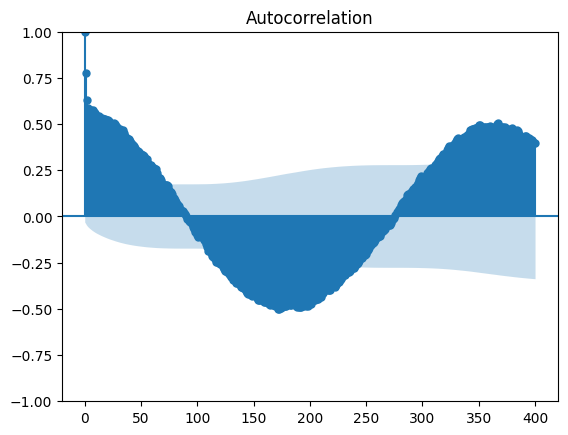

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

num_lags = 400
plot_acf(ts, lags=num_lags)
matrix = transform_to_matrix(ts, 365)

In [ ]:
matrix

,lag_365,lag_364,lag_363,lag_362,lag_361,lag_360,lag_359,lag_358,lag_357,lag_356,...,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0
1981-01-01,,,,,,,,,,,,,,,,,,,,,
1981-01-02,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,15.0,14.2,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0
1981-01-03,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.2,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5
1981-01-04,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2
1981-01-05,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2,13.0
1981-01-06,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2,13.0,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27,14.0,13.6,13.5,15.7,13.0,17.9,18.8,14.6,15.8,15.8,...,13.3,11.0,11.1,15.0,12.8,15.0,14.2,14.0,15.5,13.3
1990-12-28,13.6,13.5,15.7,13.0,17.9,18.8,14.6,15.8,15.8,15.8,...,11.0,11.1,15.0,12.8,15.0,14.2,14.0,15.5,13.3,15.6
1990-12-29,13.5,15.7,13.0,17.9,18.8,14.6,15.8,15.8,15.8,17.4,...,11.1,15.0,12.8,15.0,14.2,14.0,15.5,13.3,15.6,15.2


Добавим в модель следующие дополнительные признаки:

* Для всех обьектов добавьте в качестве признаков следующие datetime признаки (см пример в основном обзоре)

    - sin/cos проекции дня недели текущего объекта на единичный круг
    - sin/cos проекции месяца текущего объекта на единичный круг
    - sin/cos проекции дня текущего объекта на единичный круг


In [ ]:
from pandas._libs.tslibs.timestamps import Timestamp

def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*np.pi / 12)
    return np.sin(theta)

def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*np.pi / 12)
    return np.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*np.pi / timestamp.days_in_month)
    return np.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*np.pi / timestamp.days_in_month)
    return np.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*np.pi / 7)
    return np.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*np.pi / 7)
    return np.cos(theta)


datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
}

In [ ]:
for f_name, f in datetime_mappers.items():
    matrix[f_name] = matrix.index.map(f)

In [ ]:
matrix

,lag_365,lag_364,lag_363,lag_362,lag_361,lag_360,lag_359,lag_358,lag_357,lag_356,...,lag_3,lag_2,lag_1,lag_0,month_sin,month_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos
1981-01-01,,,,,,,,,,,,,,,,,,,,,
1981-01-02,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,15.2,17.4,17.0,15.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.433884,-0.900969
1981-01-03,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,17.4,17.0,15.0,13.5,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.974928,-0.222521
1981-01-04,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,17.0,15.0,13.5,15.2,5.000000e-01,0.866025,7.247928e-01,0.688967,-0.781831,0.623490
1981-01-05,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,15.0,13.5,15.2,13.0,5.000000e-01,0.866025,8.486443e-01,0.528964,0.000000,1.000000
1981-01-06,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,13.5,15.2,13.0,12.5,5.000000e-01,0.866025,9.377521e-01,0.347305,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27,14.0,13.6,13.5,15.7,13.0,17.9,18.8,14.6,15.8,15.8,...,14.2,14.0,15.5,13.3,-2.449294e-16,1.000000,-7.247928e-01,0.688967,0.433884,-0.900969
1990-12-28,13.6,13.5,15.7,13.0,17.9,18.8,14.6,15.8,15.8,15.8,...,14.0,15.5,13.3,15.6,-2.449294e-16,1.000000,-5.712682e-01,0.820763,-0.433884,-0.900969
1990-12-29,13.5,15.7,13.0,17.9,18.8,14.6,15.8,15.8,15.8,17.4,...,15.5,13.3,15.6,15.2,-2.449294e-16,1.000000,-3.943559e-01,0.918958,-0.974928,-0.222521


Разделим на train/test в соотношении примерно 0.7 на 0.3, а также на X и y

**NOTE:** Обратите внимание что тест всегда должен быть после трейна, чтобы избежать ликов из будущего, поэтому никакого stratified split!

In [ ]:
split_idx = int(len(matrix)*0.7)
train, test = matrix.iloc[:split_idx], matrix.iloc[split_idx:]

X_train, y_train = train.drop('lag_0', axis=1), train['lag_0']
X_test, y_test = test.drop('lag_0', axis=1), test['lag_0']

Обучим модель линейной регрессии из sklearn `(LinearRegression, Ridge, Lasso)`

In [ ]:
from sklearn.linear_model import Lasso

lr = Lasso()

lr.fit(X_train, y_train)

Lasso()

Сделаем in-sample прогноз на test (по сути это просто вызов метода predict на данных из теста)

Также нарисуем рядом графики прогноза.

In [ ]:
y_pred = lr.predict(X_test)

y_pred = pd.Series(y_pred, index=y_test.index)

plot_ts(y_test, y_pred)

Сделаем out-of-sample прогноз на test.

Данный прогноз делается рекурсивным способом по следующему алгоритму:

Пусть есть временной ряд $Y_T$.

1. Для следующей точки $Y_{T+1}$, в качестве лагов обьекта возьмите предыдущие `num_lags` точек.  
2. Добавьте дополнительные признаки к лагам  
3. Сделайте прогноз на полученном обьекте моделью линейной регрессии  
4. Добавьте прогноз к ряду $Y_T$  
5. Повторите пункт 1

И так далее пока не сделаeте прогноз до конца тестовой выборки.

In [ ]:
from copy import deepcopy

history = ts[:train.index[-1]]
granularity = ts.index[1] - ts.index[0]

y_pred = pd.Series()
for _ in range(len(test)):
    lags = history[-num_lags:]
    lags = lags.to_frame().T
    lags.index = [history.index[-1] + granularity]  # время следующей точки
    lags.columns = matrix.columns.drop(
        ['lag_0'] + [f for f in matrix.columns if (f.endswith('sin') or f.endswith('cos'))]
    )

    for f_name, f in datetime_mappers.items():
        lags[f_name] = lags.index.map(f)

    pred = lr.predict(lags)[0]
    y_pred = pd.concat([y_pred, pd.Series(pred, index=lags.index)])
    history = pd.concat([history, pd.Series(pred, index=lags.index)])

<ipython-input-98-c9c8e6a098f3>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series()


ValueError: ignored

In [ ]:
plot_ts(y_test, y_pred)

References.

<a id='ref_1'>[1]: [ISO durations](https://en.wikipedia.org/wiki/ISO_8601#Durations)</a>  
<a id='ref_2'>[2]: [Box-Cox transformation](http://www.machinelearning.ru/wiki/index.php?title=Метод_Бокса-Кокса)</a>  
<a id='ref_3'>[3]: [KPSS](https://en.wikipedia.org/wiki/KPSS_test)</a>  
<a id='ref_4'>[4]: [Dicky-Fuller](https://en.wikipedia.org/wiki/Dickey–Fuller_test)</a>  
<a id='ref_5'>[5]: [STL decomposition](http://www.nniiem.ru/file/news/2016/stl-statistical-model.pdf)</a>  
<a id='ref_6'>[6]: [Wold Theorem](https://ru.wikipedia.org/wiki/Теорема_Волда)</a>  
<a id='ref_7'>[7]: [Box-Jenkins approach](https://archive.org/details/timeseriesanalys0000boxg)</a>  